In [1]:
# -*- coding: utf-8 -*-
from __future__ import unicode_literals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# plt.style.use('dark_background')
%matplotlib inline

import pyLDAvis
import pyLDAvis.gensim_models as LDAGen

# to ignore plt warnings, not good practice but hey
import warnings
warnings.filterwarnings("ignore")

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
import gensim.corpora as corpora
from pprint import pprint

# own utility modules
import mods.text as text
import mods.lyrics as lyrics
import replacements as replacements

## 0. Data Pre-Processing

In [2]:
# read data
raw = pd.read_csv('./data/lyrics.csv', encoding='utf8')
df = raw.copy()

# set column types
df['album_rd'] = df['album_rd'].astype('datetime64[ns]')

# add column to reflect year track is released in df
df['year'] = df['album_rd'].dt.year

# copy of df before filtering
unfiltered_df = df.copy()

# remove tracks with no lyrics
df = df[df['lyrics'].notna()]

# remove duplicate tracks (non-repackaged, not remix, not short versions)
df = df[~df['repackaged'] & ~df['remix'] & ~df['has_full_ver']]

# remove album extras (not tracks)
df = df[~df['track_title'].str.contains('notes', case=False) & ~df['track_title'].str.contains('skit', case=False)]

# fill null with "NA"
df = df.fillna('NA')

df.columns

Index(['id', 'album_title', 'eng_album_title', 'album_rd', 'album_seq',
       'track_title', 'kor_track_title', 'eng_track_title', 'lyrics',
       'hidden_track', 'remix', 'featured', 'performed_by', 'repackaged',
       'lang', 'has_full_ver', 'year'],
      dtype='object')

In [3]:
def pre_normalise(text):
    '''
    function to replace text before normalisation
    '''
    replacements = {'ille~gal': 'illegal gal', 'k-pop': 'kpop'}    
    replaced = [replacements[word] if word in replacements.keys() else word for word in text.lower().split()]
    return ' '.join(replaced)
    
df['lyrics'] = df['lyrics'].apply(lambda x: pre_normalise(x))

# expand lyrical contractions
df['lyrics'] = df['lyrics'].apply(lambda x: lyrics.expand_contractions(x))

# normalises lyrics (make text all lowercase, remove punctuation)
to_replace = replacements.replace_list.copy()
to_replace.update(lyrics.CONTRACTIONS)
df['lyrics'] = df['lyrics'].apply(lambda x: text.normalise(x, expand_contractions=True, replacements=to_replace))

# remove adlibs
df['lyrics'] = df['lyrics'].apply(lambda x: lyrics.remove_non_lex_vocables(x))

# do not include tracks that normalises to empty lyrics
df = df[df['lyrics'].str.len() > 0]

df.describe()

,id,album_seq,year
count,130.000000,130.000000,130.000000
mean,106.146154,7.115385,2016.392308
std,66.904550,4.711251,2.347673
min,0.000000,1.000000,2013.000000
25%,49.250000,3.000000,2014.000000
50%,103.500000,6.000000,2016.000000
75%,161.000000,10.000000,2018.000000
max,224.000000,19.000000,2020.000000


## 1. Prepare Model Inputs

In [4]:
# corpus
doc_clean = [l.split() for l in list(df['lyrics'])]

# Creating the term dictionary of courpus, every unique term is assigned an index.
dictionary = corpora.Dictionary(doc_clean)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

## 2.1 Base Model

In [5]:
def compute_coherence_value(doc_term_matrix, dictionary, doc_clean, num_topics, alpha, beta):
    '''
    returns the lda_model and coherence value of lda multicore model
    '''
    lda_model = LdaMulticore(
                    corpus=doc_term_matrix,
                    num_topics=num_topics,
                    id2word = dictionary,
                    passes = 15,
                    alpha=alpha,
                    eta=beta)
    coherencemodel = CoherenceModel(model=lda_model,
                        texts=doc_clean,
                        dictionary=dictionary,
                        coherence='c_v')        
    return lda_model, coherencemodel.get_coherence()

In [6]:
model_list = []

In [7]:
# base model parameters
n = 5
a = 0.01
b = 0.1

model, c_v = compute_coherence_value(doc_term_matrix, dictionary, doc_clean, n, a, b)
model_list.append({'name': 'base', 'n': n, 'a': a, 'b': b, 'c_v': c_v, 'model': model})
print('base model c_v: {0:.4f}'.format(c_v))

base model c_v: 0.2907


## 2.2 Model 1: Changing Number of Topics

In [8]:
# other model parameters
a = 0.01
b = 0.1

# range for number of topics
num_topics_range = range(2, 11, 1)
model1_list = []
coherence_values = []

for n in num_topics_range:
    m, c = compute_coherence_value(doc_term_matrix, dictionary, doc_clean, n, a, b)
    model1_list.append(m)
    coherence_values.append(c)

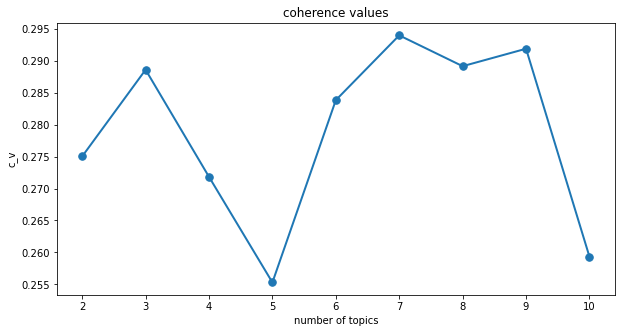

In [9]:
plt.figure(figsize=(10,5))
plt.xticks(num_topics_range)
plt.title('coherence values')
plt.xlabel('number of topics')
plt.ylabel('c_v')

plt.plot(num_topics_range, coherence_values, '.-', linewidth=2, markersize=15)

In [10]:
pd.DataFrame(zip(num_topics_range, coherence_values), columns=['num topics', 'coherence'])

,num topics,coherence
0,2,0.275036
1,3,0.288596
2,4,0.271831
3,5,0.255301
4,6,0.283837
5,7,0.293980
6,8,0.289153
7,9,0.291885
8,10,0.259327


In [11]:
n = num_topics_range[coherence_values.index(max(coherence_values))]
model = model1_list[coherence_values.index(max(coherence_values))]
c_v = max(coherence_values)

model_list.append({'name': 'model 1', 'n': n, 'a': a, 'b': b, 'c_v': c_v, 'model': model})
print('number of topics that yield highest coherence value: {}'.format(n))
print('model 1 c_v: {0:.4f}'.format(c_v))

number of topics that yield highest coherence value: 7
model 1 c_v: 0.2940


Chosen the number of topics that result in the highest coherence value, stored in variable `n`

## 2.2 Model 2: Changing alpha values

In [12]:
# other model parameters
b = 0.1

# range for slpha values
alpha_list = list(np.arange(0.01, 1, 0.1))
alpha_list.append('symmetric')
alpha_list.append('asymmetric')

model2_list = []
coherence_values = []

for a in alpha_list:
    m, c = compute_coherence_value(doc_term_matrix, dictionary, doc_clean, n, a, b)
    model2_list.append(m)
    coherence_values.append(c)

In [13]:
pd.DataFrame(zip(alpha_list, coherence_values), columns=['alpha', 'coherence'])

,alpha,coherence
0,0.01,0.263501
1,0.11,0.260578
2,0.21,0.273480
3,0.31,0.293115
4,0.41,0.269816
5,0.51,0.289430
6,0.61,0.261908
7,0.71,0.293196
8,0.81,0.261735
9,0.91,0.272151


In [14]:
a = alpha_list[coherence_values.index(max(coherence_values))]
model = model2_list[coherence_values.index(max(coherence_values))]
c_v = max(coherence_values)

model_list.append({'name': 'model 2', 'n': n, 'a': a, 'b': b, 'c_v': c_v, 'model': model})
print('alpha value that yield highest coherence value: {}'.format(a))
print('model 2 c_v: {0:.4f}'.format(c_v))

alpha value that yield highest coherence value: 0.7100000000000001
model 2 c_v: 0.2932


## Model 3: Changing eta (b) values

In [15]:
# range for eta values
beta_list = list(np.arange(0.01, 1, 0.1))
beta_list.append('symmetric')

model3_list = []
coherence_values = []

for b in beta_list:
    m, c = compute_coherence_value(doc_term_matrix, dictionary, doc_clean, n, a, b)
    model3_list.append(m)
    coherence_values.append(c)

In [34]:
pd.DataFrame(zip(beta_list, coherence_values), columns=['eta', 'coherence'])

,eta,coherence
0,0.01,0.295652
1,0.11,0.274997
2,0.21,0.272987
3,0.31,0.271224
4,0.41,0.272174
5,0.51,0.294139
6,0.61,0.267188
7,0.71,0.286647
8,0.81,0.294003
9,0.91,0.397693


In [17]:
b = beta_list[coherence_values.index(max(coherence_values))]
model = model3_list[coherence_values.index(max(coherence_values))]
c_v = max(coherence_values)

model_list.append({'name': 'model 3', 'n': n, 'a': a, 'b': b, 'c_v': c_v, 'model': model})
print('eta value that yield highest coherence value: {}'.format(b))
print('model 3 c_v: {0:.4f}'.format(max(coherence_values)))

eta value that yield highest coherence value: 0.91
model 3 c_v: 0.3977


## Selecting Final Model

In [18]:
model_list

[{'name': 'base',
  'n': 5,
  'a': 0.01,
  'b': 0.1,
  'c_v': 0.2907123444080351,
  'model': <gensim.models.ldamulticore.LdaMulticore at 0x7fc61772a650>},
 {'name': 'model 1',
  'n': 7,
  'a': 0.01,
  'b': 0.1,
  'c_v': 0.29398008102773654,
  'model': <gensim.models.ldamulticore.LdaMulticore at 0x7fc6181d42d0>},
 {'name': 'model 2',
  'n': 7,
  'a': 0.7100000000000001,
  'b': 0.1,
  'c_v': 0.29319623320394106,
  'model': <gensim.models.ldamulticore.LdaMulticore at 0x7fc632fb2f90>},
 {'name': 'model 3',
  'n': 7,
  'a': 0.7100000000000001,
  'b': 0.91,
  'c_v': 0.3976930212627398,
  'model': <gensim.models.ldamulticore.LdaMulticore at 0x7fc61806ef50>}]

In [19]:
model_cv_values = [m['c_v'] for m in model_list]
selected_model = model_list[model_cv_values.index(max(model_cv_values))]
selected_model

{'name': 'model 3',
 'n': 7,
 'a': 0.7100000000000001,
 'b': 0.91,
 'c_v': 0.3976930212627398,
 'model': <gensim.models.ldamulticore.LdaMulticore at 0x7fc61806ef50>}

In [57]:
model_list[3]['model']

In [20]:
lda = selected_model['model']

In [53]:
# display topics and associated words
for topic in lda.show_topics(num_words=15):
    # print('Topic {}'.format(topic[0]))
    # printmd('**Topic {}**'.format(topic[0]))
    # print('Topic {}: '.format(topic[0]), end="")
    topic_words = topic[1]
    topic_words = [t.strip().split('*') for t in topic_words.split('+')]
    temp = pd.DataFrame(topic_words, columns=['prob', 'word'])
    temp['word'] = temp['word'].apply(lambda x: x.replace('\"', ''))
    words_in_topic = ' '.join(list(temp['word']))
    print('Topic {}: {}'.format(topic[0], words_in_topic))

Topic 0: let jump us hand go save get light shine night bring thing dynamite dream come
Topic 1: go run say like ugh make turn yolo even look world squandering back worry fun
Topic 2: drink respect one today day sunday shot fall hand say two everyone glass party ready
Topic 3: go like want get say day know look even dream one heart baby come right
Topic 4: love let us try mama live like fake get hold move make know go become
Topic 5: know want love like even cannot go time let girl way feel fine stay get
Topic 6: bang everyday still year blink grade 2 eye burn second teacher fast chased chain junior


In [21]:
# display topics, related words and their probability
# https://stackoverflow.com/questions/23271575/printing-bold-colored-etc-text-in-ipython-qtconsole
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

for topic in lda.show_topics(num_words=15):
    # print('Topic {}'.format(topic[0]))
    printmd('**Topic {}**'.format(topic[0]))
    topic_words = topic[1]
    topic_words = [t.strip().split('*') for t in topic_words.split('+')]
    temp = pd.DataFrame(topic_words, columns=['prob', 'word'])
    temp['word'] = temp['word'].apply(lambda x: x.replace('\"', ''))
    print(temp.to_string(index=False))
    print()

**Topic 0**

 prob     word
0.018      let
0.015     jump
0.014       us
0.009     hand
0.008       go
0.006     save
0.006      get
0.006    light
0.005    shine
0.005    night
0.005    bring
0.005    thing
0.005 dynamite
0.004    dream
0.004     come



**Topic 1**

 prob        word
0.012          go
0.010         run
0.009         say
0.006        like
0.006         ugh
0.005        make
0.005        turn
0.005        yolo
0.005        even
0.004        look
0.004       world
0.004 squandering
0.004        back
0.004       worry
0.004         fun



**Topic 2**

 prob     word
0.012    drink
0.011  respect
0.011      one
0.009    today
0.008      day
0.006   sunday
0.005     shot
0.005     fall
0.004     hand
0.004      say
0.003      two
0.003 everyone
0.003    glass
0.003    party
0.003    ready



**Topic 3**

 prob  word
0.023    go
0.018  like
0.015  want
0.011   get
0.010   say
0.010   day
0.009  know
0.008  look
0.008  even
0.008 dream
0.007   one
0.006 heart
0.006  baby
0.006  come
0.005 right



**Topic 4**

 prob   word
0.036   love
0.017    let
0.010     us
0.006    try
0.005   mama
0.005   live
0.005   like
0.004   fake
0.004    get
0.004   hold
0.004   move
0.004   make
0.004   know
0.004     go
0.003 become



**Topic 5**

 prob   word
0.021   know
0.017   want
0.017   love
0.014   like
0.012   even
0.011 cannot
0.009     go
0.007   time
0.006    let
0.006   girl
0.006    way
0.006   feel
0.006   fine
0.005   stay
0.005    get



**Topic 6**

 prob     word
0.023     bang
0.005 everyday
0.005    still
0.003     year
0.003    blink
0.003    grade
0.002        2
0.002      eye
0.002     burn
0.002   second
0.002  teacher
0.002     fast
0.001   chased
0.001    chain
0.001   junior



In [22]:
temp_topic_columns = {'topic_{}'.format(i):None for i in range(0,selected_model['n'])}
temp_topic_columns

{'topic_0': None,
 'topic_1': None,
 'topic_2': None,
 'topic_3': None,
 'topic_4': None,
 'topic_5': None,
 'topic_6': None}

In [79]:
# set name to topics
temp_topic_columns = {'topic_0': 'optimism',
                    'topic_1': 'yolo',
                    'topic_2': 'party',
                    'topic_3': 'dreamy love',
                    'topic_4': 'realistic love',
                    'topic_5': 'missed love',
                    'topic_6': 'kid love'}

In [80]:
# display new topic labels and associated words
for topic in lda.show_topics(num_words=15):
    topic_words = topic[1]
    topic_words = [t.strip().split('*') for t in topic_words.split('+')]
    temp = pd.DataFrame(topic_words, columns=['prob', 'word'])
    temp['word'] = temp['word'].apply(lambda x: x.replace('\"', ''))
    words_in_topic = ' '.join(list(temp['word']))
    print('Topic {} -> {}: {}'.format(topic[0], temp_topic_columns['topic_{}'.format(topic[0])], words_in_topic))

Topic 0 -> optimism: let jump us hand go save get light shine night bring thing dynamite dream come
Topic 1 -> yolo: go run say like ugh make turn yolo even look world squandering back worry fun
Topic 2 -> party: drink respect one today day sunday shot fall hand say two everyone glass party ready
Topic 3 -> dreamy love: go like want get say day know look even dream one heart baby come right
Topic 4 -> realistic love: love let us try mama live like fake get hold move make know go become
Topic 5 -> missed love: know want love like even cannot go time let girl way feel fine stay get
Topic 6 -> kid love: bang everyday still year blink grade 2 eye burn second teacher fast chased chain junior


In [23]:
tdf = df.copy()
tdf = tdf.join(pd.DataFrame(temp_topic_columns, index=tdf.index))
tdf.describe()

,id,album_seq,year
count,130.000000,130.000000,130.000000
mean,106.146154,7.115385,2016.392308
std,66.904550,4.711251,2.347673
min,0.000000,1.000000,2013.000000
25%,49.250000,3.000000,2014.000000
50%,103.500000,6.000000,2016.000000
75%,161.000000,10.000000,2018.000000
max,224.000000,19.000000,2020.000000


In [24]:
def apply_lda(row):
    row_index = row.name
    text = row.lyrics
    doc = dictionary.doc2bow(text.split())
    # print(new_doc_bow)

    topic_scores = lda.get_document_topics(doc)
    for topic in topic_scores:
        # print(topic)
        col_name = 'topic_{}'.format(topic[0])
        # print(col_name)
        # print(type(topic[1]))
        tdf.at[row_index, col_name] = topic[1]
    # return lda.get_document_topics(doc)
    pass

In [25]:
tdf.apply(lambda x: apply_lda(x), axis=1)
tdf.filter(regex=("topic_*|^(track_title)"))
tdf.dtypes

id                          int64
album_title                object
eng_album_title            object
album_rd           datetime64[ns]
album_seq                   int64
track_title                object
kor_track_title            object
eng_track_title            object
lyrics                     object
hidden_track                 bool
remix                        bool
featured                   object
performed_by               object
repackaged                   bool
lang                       object
has_full_ver                 bool
year                        int64
topic_0                    object
topic_1                    object
topic_2                    object
topic_3                    object
topic_4                    object
topic_5                    object
topic_6                    object
dtype: object

In [26]:
for k in temp_topic_columns.keys():
    tdf[k] = tdf[k].astype(float)
tdf.dtypes

id                          int64
album_title                object
eng_album_title            object
album_rd           datetime64[ns]
album_seq                   int64
track_title                object
kor_track_title            object
eng_track_title            object
lyrics                     object
hidden_track                 bool
remix                        bool
featured                   object
performed_by               object
repackaged                   bool
lang                       object
has_full_ver                 bool
year                        int64
topic_0                   float64
topic_1                   float64
topic_2                   float64
topic_3                   float64
topic_4                   float64
topic_5                   float64
topic_6                   float64
dtype: object

In [81]:
# take highest topic score and store the topic in column 'topic'
tdf['topic']=tdf.filter(regex=("topic_[0-9]{1}")).idxmax(axis=1)

In [90]:
trimmed = tdf[['track_title', 'album_title', 'topic', 'year']]
# rename topics to labels
trimmed['topic'] = trimmed['topic'].apply(lambda t: temp_topic_columns[t])
trimmed.groupby(by=['topic']).agg({
    'track_title': 'count'
}).rename(columns={'track_title': 'Number of Tracks'})

,Number of Tracks
topic,
dreamy love,44
kid love,1
missed love,41
optimism,14
party,3
realistic love,13
yolo,14


In [29]:
pyLDAvis.enable_notebook()
vis = LDAGen.prepare(lda, doc_term_matrix, dictionary)
vis

1651           fun
581       3  0.281461           fun
3348      1  0.184957          funk
3348      2  0.184957          funk
3348      5  0.554870          funk
550       1  0.402943          game
550       2  0.067157          game
550       3  0.134314          game
550       4  0.335786          game
550       5  0.067157          game
994       1  0.160032       gangwon
994       2  0.160032       gangwon
994       5  0.640129       gangwon
3294      1  0.146289          gaze
3294      2  0.292579          gaze
3294      5  0.438868          gaze
57        1  0.603846           get
57        2  0.215659           get
57        3  0.043132           get
57        4  0.048523           get
57        5  0.070089           get
57        6  0.016174           get
727       1  0.139809          gift
727       2  0.139809          gift
727       3  0.559238          gift
728       1  0.318750          girl
728       2  0.499375          girl
728       3  0.106250          girl
728       5  0.063750          girl
58        1  0.454738          give
58        2  0.257685          give
58        3  0.181895          give
58        4  0.015158          give
58        5  0.090948          give
788       1  0.401680         glass
788       2  0.100420         glass
788       6  0.401680         glass
17        1  0.628999            go
17        2  0.192928            go
17        3  0.108357            go
17        4  0.021143            go
17        5  0.044928            go
17        6  0.002643            go
226       1  0.759675          good
226       2  0.132117          good
226       3  0.049544          good
226       4  0.033029          good
226       5  0.016515          good
2016      1  0.256850         grade
2016      2  0.256850         grade
2016      7  0.256850         grade
3145      1  0.254162         grape
3145      2  0.254162         grape
3145      6  0.254162         grape
324       1  0.374203         great
324       2  0.062367         great
324       3  0.498937         great
2017      1  0.327332       greeted
2017      2  0.327332       greeted
2018      1  0.128988          grew
2018      2  0.128988          grew
2018      3  0.128988          grew
2018      4  0.644942          grew
2519      1  0.229564      gripping
2519      2  0.229564      gripping
2519      4  0.229564      gripping
2519      6  0.229564      gripping
2662      1  0.201343           gun
2662      2  0.201343           gun
2662      6  0.402686           gun
551       1  0.269653          hand
551       2  0.382009          hand
551       3  0.056178          hand
551       4  0.022471          hand
551       5  0.213475          hand
551       6  0.056178          hand
60        1  0.424885          hard
60        2  0.326834          hard
60        3  0.065367          hard
60        4  0.196101          hard
60        5  0.032683          hard
858       1  0.173789        harder
858       2  0.086894        harder
858       3  0.086894        harder
858       4  0.521366        harder
2325      1  0.218728         hards
2325      2  0.218728         hards
2325      4  0.437456         hards
649       1  0.079402         hater
649       2  0.317609         hater
649       3  0.555816         hater
228       1  0.720410         heart
228       2  0.171526         heart
228       3  0.034305         heart
228       4  0.057175         heart
228       5  0.011435         heart
228       6  0.011435         heart
995       1  0.122928         hello
995       2  0.184392         hello
995       3  0.553177         hello
995       4  0.061464         hello
995       5  0.061464         hello
1431      1  0.081019          hero
1431      2  0.162038          hero
1431      3  0.486113          hero
1431      4  0.081019          hero
1431      5  0.162038          hero
483       1  0.133733          high
483       2  0.802398          high
483       3  0.022289          high
483       5  0.022289          high
483       6  0.022289

In [30]:
from datetime import datetime
import os
timestamp = datetime.now().strftime("%d%b%Y_%H%M%S")
os.mkdir('models/{}'.format(timestamp))
model_save_path = 'models/{}/lda_{}'.format(timestamp, timestamp)
lda.save(model_save_path)
print('saved lda model to file: {}'.format(model_save_path))

saved lda model to file: models/02May2021_112456/lda_02May2021_112456


In [98]:
# savw vis
# pyLDAvis.save_html(vis, 'vis.html')

In [140]:
topics_df = trimmed.copy()

In [170]:
topics_df = trimmed.groupby(by=['topic','album_title']).agg({
            'track_title': 'count'
            }).unstack(fill_value=0).stack()

topics_df = topics_df.reset_index()
topics_df['year'] = topics_df['album_title'].apply(lambda a: list(df[df['album_title']==a]['year'].unique())[0])
topics_df['min_id'] = topics_df['album_title'].apply(lambda a: df[df['album_title']==a]['id'].min())

topics_df = topics_df.sort_values(by='min_id')

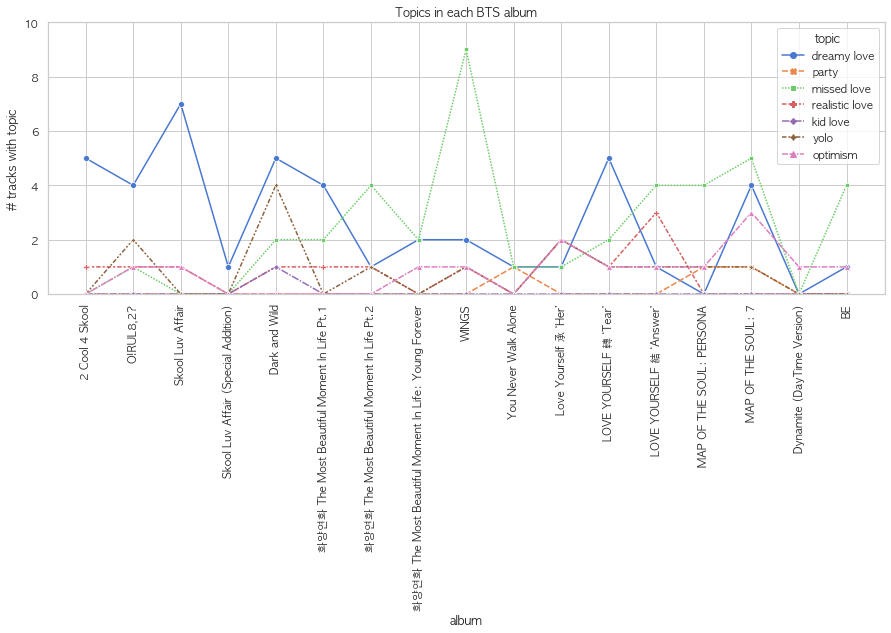

In [172]:
import seaborn as sns
sns.set(style='whitegrid', font='AppleGothic', rc={'figure.figsize':(15,5)})
sns.set_palette(palette='muted')
plt.xticks(rotation=90)
plt.ylim(0, topics_df['track_title'].max()+1)
ax = sns.lineplot(x='album_title', y='track_title', hue='topic', data=topics_df.reset_index(), markers=True, style='topic')
ax.set(xlabel='album', ylabel='# tracks with topic', title='Topics in each BTS album')
# ax.grid(False)
ax.figure.savefig("topic_trend.png", bbox_inches='tight')